In [2]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"umashreeworkspace31","key":"9359ead33f664b8475d6a161fdbe8734"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d adityajn105/flickr8k


Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
100% 1.04G/1.04G [00:48<00:00, 24.2MB/s]
100% 1.04G/1.04G [00:48<00:00, 23.0MB/s]


In [5]:
import zipfile
with zipfile.ZipFile("flickr8k.zip", 'r') as zip_ref:
  zip_ref.extractall("dataset")



In [6]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm

#NLP Imports
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Flatten, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Input, Dense, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
#Model Creation Imports
from tensorflow.keras.models import Sequential, Model
from keras.applications import DenseNet201
from keras.models import Model

#Computer Vision Imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import DenseNet201

#Model Learning & Losses Imports
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#Warning and Visualization Imports
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [7]:
import pandas as pd
image_path = "dataset/Images"
data = pd.read_csv("dataset/captions.txt")
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


Image **Captioning**

Image Captioning is the process of generating textual description of an image. It uses both Natural Language Processing and Computer Vision to generate the captions.

I've used CNNs + RNNs (LSTMs)

*  To perform Image Captioning we will require two deep learning models combined into one for the training purpose.

*   CNNs extract the features from the image of some vector size aka the vector embeddings. The size of these embeddings depend on the type of pretrained network being used for the feature extraction.
*   LSTMs are used for the text generation process. The image embeddings are concatenated with the word embeddings and passed to the LSTM to generate the next word.


*   For a more illustrative explanation of this architecture check the Modelling section for a picture representation.







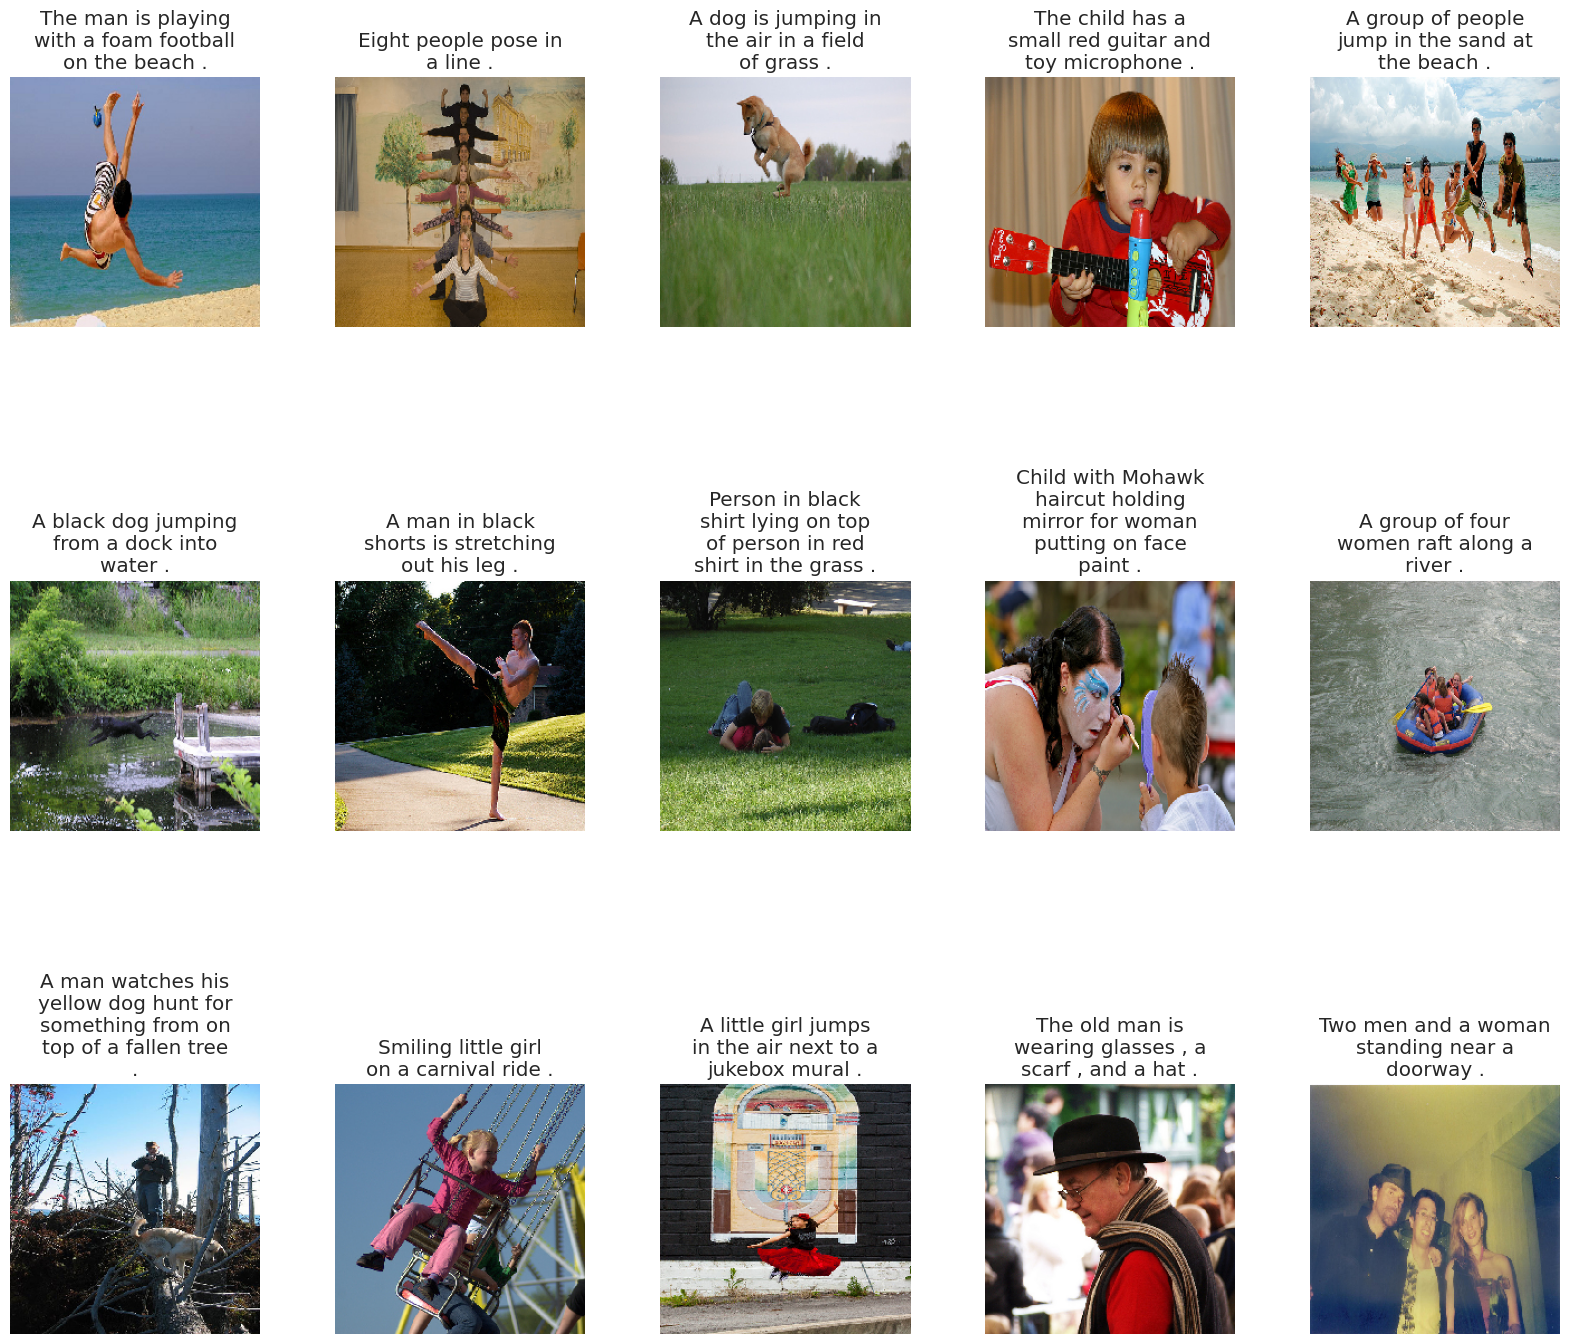

In [8]:
def readImage(path, img_size = 224):
    img = load_img(path, color_mode = 'rgb', target_size = (img_size, img_size))
    img = img_to_array(img)
    img = img/255. #(0-1)
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop = True)
    plt.figure(figsize = (20,30))
    n = 0
    for i in range(15):
        n += 1
        plt.subplot(5,5,n)
        plt.subplots_adjust(hspace = 0.7,wspace = 0.3)
        image = readImage(f"dataset/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title('\n'.join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

display_images(data.sample(15))

**Visualization**



*   above picture is showing the Images and their corresponding captions.




**Caption Text Preprocessing Steps**







*   Convert sentences into lowercase

*   Remove special characters and numbers present in the text

*   Remove extra spaces
*   Remove single characters


*   Add a starting and an ending tag to the sentences to indicate the beginning and the ending of a sentence





In [9]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z", ""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+", " "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

data = text_preprocessing(data)
captions = data['caption'].tolist()
data

,image,caption
0,1000268201_693b08cb0e.jpg,startseq child in pink dress is climbing up se...
1,1000268201_693b08cb0e.jpg,startseq girl going into wooden building endseq
2,1000268201_693b08cb0e.jpg,startseq little girl climbing into wooden play...
3,1000268201_693b08cb0e.jpg,startseq little girl climbing the stairs to he...
4,1000268201_693b08cb0e.jpg,startseq little girl in pink dress going into ...
...,...,...
40450,997722733_0cb5439472.jpg,startseq man in pink shirt climbs rock face en...
40451,997722733_0cb5439472.jpg,startseq man is rock climbing high in the air ...
40452,997722733_0cb5439472.jpg,startseq person in red shirt climbing up rock ...
40453,997722733_0cb5439472.jpg,startseq rock climber in red shirt endseq


Above output is showing Preprocessed Text corresponding images.




**Tokenization and Encoded Representation**

*   The words in a sentence are separated/tokenized and encoded in a one hot representation
*   These encodings are then passed to the embeddings layer to generate word embeddings.






In [24]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max([len(caption.split()) for caption in captions])

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

#train and test dataset
train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace = True, drop = True)
test.reset_index(inplace = True, drop = True)

tokenizer.texts_to_sequences([captions[1]])[0]


[1, 18, 315, 63, 195, 116, 2]

**Image Feature Extraction**



*   DenseNet 201 Architecture is used to extract the features from the images

*   Any other pretrained architecture can also be used for extracting features from these images
*   Since the Global Average Pooling layer is selected as the final layer of the DenseNet201 model for our feature extraction, our image embeddings will be a vector of size 1920








In [11]:
from keras.applications import DenseNet201
from keras.models import Model


model = DenseNet201()
fe = Model(inputs = model.input, outputs = model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path, image), target_size = (img_size, img_size))
    img = img_to_array(img)
    img = img/255
    img = np.expand_dims(img, axis = 0)
    feature = fe.predict(img, verbose = 0)
    features[image] = feature

82524592/82524592 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


100%|██████████| 8091/8091 [13:42<00:00,  9.84it/s]


**Data Generation**





*   Since Image Caption model training like any other neural network training is a highly resource utillizing process we cannot load the data into the main memory all at once, and hence we need to generate the data in the required format batch wise

*   The inputs will be the image embeddings and their corresonding caption text embeddings for the training process
*   The text embeddings are passed word by word for the caption generation during inference time





In [12]:
from tensorflow.keras.utils import Sequence
class CustomDataGenerator(Sequence):
    def __init__(self, df, x_col, y_col, batch_size, directory, tokenizer, vocab_size, max_length, features, shuffle = True):
        self.df = df.copy()
        self.x_col = x_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac = 1).reset_index(drop = True)

    def __len__(self):
        return int(np.ceil(self.n / self.batch_size))
        #return self.n #self.batch_size

    def __getitem__(self, index):
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size, :]
        x1, x2, y = self.__get_data(batch)
        return (x1, x2), y


    def __get_data(self, batch):
        x1, x2, y = list(), list(), list()
        images = batch[self.x_col].tolist()

        for image in images:
            feature = self.features[image][0]
            captions = batch.loc[batch[self.x_col] == image, self.y_col]. tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen = self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes = self.vocab_size)[0]
                    x1.append(feature)
                    x2.append(in_seq)
                    y.append(out_seq)

        x1, x2, y = np.array(x1), np.array(x2), np.array(y)
        return x1, x2, y



train_generator = CustomDataGenerator(df = train, x_col = 'image', y_col = 'caption', batch_size = 64, directory = image_path, tokenizer = tokenizer, vocab_size = vocab_size, max_length = max_length, features = features)

validation_generator = CustomDataGenerator(df = test, x_col = 'image', y_col = 'caption', batch_size = 64, directory = image_path, tokenizer = tokenizer, vocab_size = vocab_size, max_length = max_length, features = features)

In [13]:
x, y = train_generator[0]
print(x[0].shape)
print("x2 shape:", x[1].shape)
print("y shape:", y.shape)

(3543, 1920)
x2 shape: (3543, 34)
y shape: (3543, 8485)


In [14]:
for key, value in features.items():
    if value[0].shape != (1920,):
        print(f"Feature for {key} has incorrect shape: {value[0].shape}")
    else:
        print(f"Feature for {key} has correct shape: {value[0].shape}")


Streaming output truncated to the last 5000 lines.
Feature for 2844747252_64567cf14a.jpg has correct shape: (1920,)
Feature for 2844846111_8c1cbfc75d.jpg has correct shape: (1920,)
Feature for 2844963839_ff09cdb81f.jpg has correct shape: (1920,)
Feature for 2845246160_d0d1bbd6f0.jpg has correct shape: (1920,)
Feature for 2845691057_d4ab89d889.jpg has correct shape: (1920,)
Feature for 2845845721_d0bc113ff7.jpg has correct shape: (1920,)
Feature for 2846037553_1a1de50709.jpg has correct shape: (1920,)
Feature for 2846785268_904c5fcf9f.jpg has correct shape: (1920,)
Feature for 2846843520_b0e6211478.jpg has correct shape: (1920,)
Feature for 2847514745_9a35493023.jpg has correct shape: (1920,)
Feature for 2847615962_c330bded6e.jpg has correct shape: (1920,)
Feature for 2847859796_4d9cb0d31f.jpg has correct shape: (1920,)
Feature for 2848266893_9693c66275.jpg has correct shape: (1920,)
Feature for 2848571082_26454cb981.jpg has correct shape: (1920,)
Feature for 2848895544_6d06210e9d.jpg h

**Modeling**


*   The image embedding representations are concatenated with the first word of sentence ie. starseq and passed to the LSTM network.
*   The LSTM network starts generating words after each input thus forming a sentence at the end.





In [15]:
from tensorflow.keras.utils import plot_model

input1 = Input(shape=(1920,))
input2 = Input(shape = (max_length,))

img_features = Dense(256, activation = 'relu')(input1)
img_features_reshaped = Reshape((1,256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero = False)(input2)
merged = concatenate([img_features_reshaped, sentence_features], axis = 1)
sentence_features = LSTM(256)(merged)

x = Dropout(0.5)(sentence_features)
x = add([x, img_features])

x = Dense(128, activation = 'relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation = 'softmax')(x)

caption_model = Model(inputs = [input1, input2], outputs = output)
caption_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

from tensorflow.keras.callbacks import ModelCheckpoint

#Define the mode checkpoint
model_name = "model.keras"
checkpoint = ModelCheckpoint(
    model_name,
    monitor = "val_loss",
    mode = "min",
    save_best_only = True,
    save_weights_only = False,
    verbose = 1
)


earlystopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss',
                                            patience = 3,
                                            factor = 0.2,
                                            min_lr = 0.00000001)

history = caption_model.fit(train_generator,
                            epochs = 50,
                            validation_data = validation_generator,
                            callbacks = [checkpoint, earlystopping, learning_rate_reduction])



Epoch 1/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - loss: 5.6705
Epoch 1: val_loss improved from inf to 4.16744, saving model to model.keras
538/538 ━━━━━━━━━━━━━━━━━━━━ 367s 662ms/step - loss: 5.6693 - val_loss: 4.1674 - learning_rate: 0.0010
Epoch 2/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 4.1935
Epoch 2: val_loss improved from 4.16744 to 3.88169, saving model to model.keras
538/538 ━━━━━━━━━━━━━━━━━━━━ 106s 163ms/step - loss: 4.1934 - val_loss: 3.8817 - learning_rate: 0.0010
Epoch 3/50
537/538 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 3.9268
Epoch 3: val_loss improved from 3.88169 to 3.75370, saving model to model.keras
538/538 ━━━━━━━━━━━━━━━━━━━━ 137s 155ms/step - loss: 3.9267 - val_loss: 3.7537 - learning_rate: 0.0010
Epoch 4/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 3.7544
Epoch 4: val_loss improved from 3.75370 to 3.68787, saving model to model.keras
538/538 ━━━━━━━━━━━━━━━━━━━━ 83s 153ms/step - loss: 3.7544 - val_loss: 3.6879 - learning_rate: 0.00

In [16]:
history.history

{'loss': [5.024590015411377,
  4.138731956481934,
  3.901190996170044,
  3.7473549842834473,
  3.6349897384643555,
  3.546313762664795,
  3.4734609127044678,
  3.413700580596924,
  3.3562090396881104,
  3.307847738265991,
  3.2637124061584473,
  3.158620595932007,
  3.135648250579834],
 'val_loss': [4.1674370765686035,
  3.8816850185394287,
  3.753704071044922,
  3.6878740787506104,
  3.642216205596924,
  3.625683546066284,
  3.6153228282928467,
  3.607226848602295,
  3.617522716522217,
  3.614008665084839,
  3.628166675567627,
  3.6430904865264893,
  3.6341066360473633],
 'learning_rate': [0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.00020000000949949026,
  0.00020000000949949026]}

**Learning Curve**



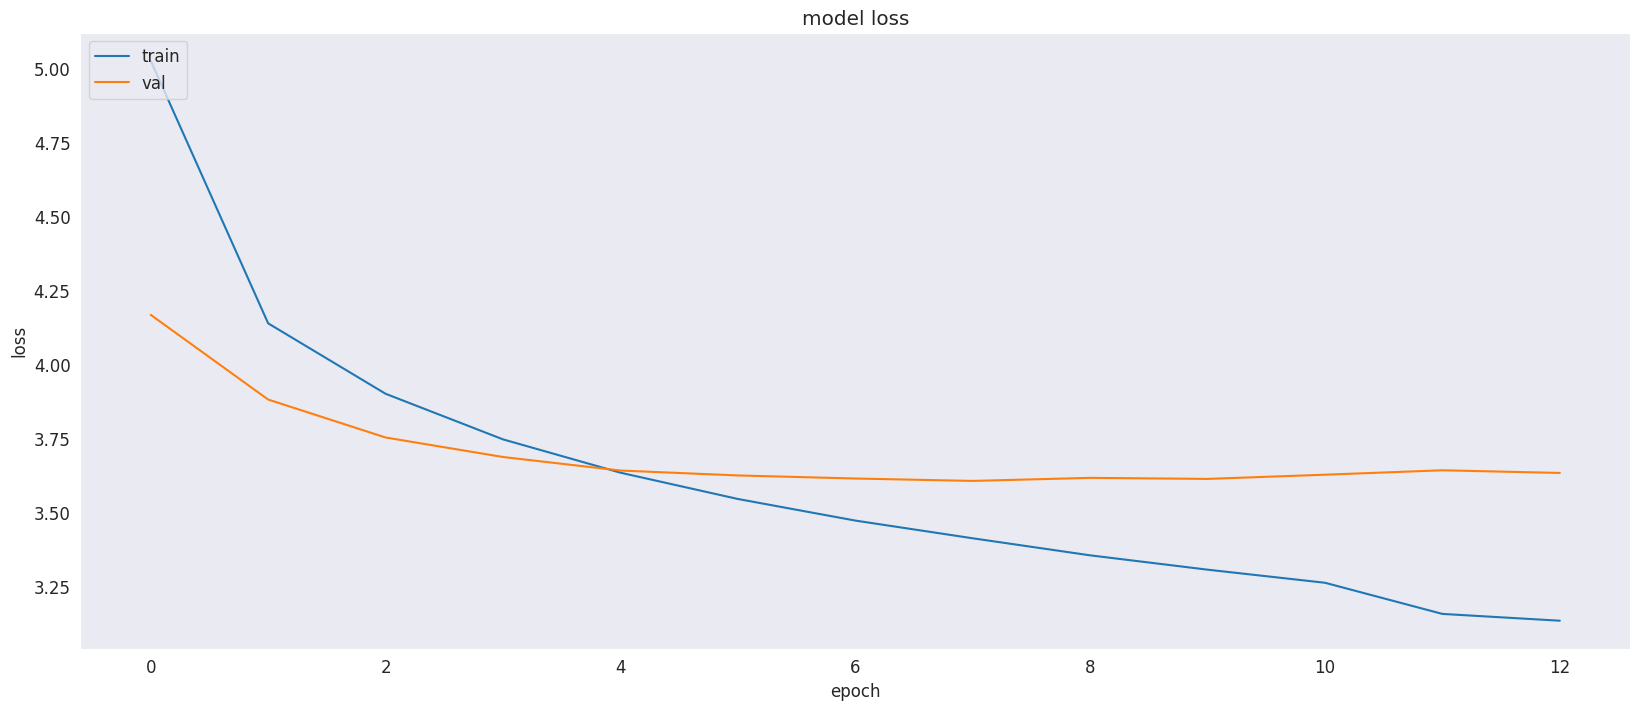

In [17]:
plt.figure(figsize = (20, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()



**Caption Generation Utility Functions**


*   Utility functions to generate the captions of input images at the inference time.
*   Here the image embeddings are passed along with the first word, followed by which the text embedding of each new word is passed to generate the next word.





In [18]:
import pickle

#save the tokenizer
with open("tokenizer.pkl", "wb") as f:
  pickle.dump(tokenizer, f)

#save the feature extractor model
fe.save("feature_extractor.keras")




In [19]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import pickle

#load save files
model_path = "model.keras"
tokenizer_path = "tokenizer.pkl"
feature_extractor_path = "feature_extractor.keras"

def generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path, max_length = 34, img_size = 224):
  #load the trained models and tokenizer
  caption_model = load_model(model_path)
  feature_extractor = load_model(feature_extractor_path)

  with open(tokenizer_path, "rb") as f:
    tokenizer = pickle.load(f)

  #preprocessing the image
  img = load_img(image_path, target_size = (img_size, img_size))
  img = img_to_array(img) / 255.0
  img =  np.expand_dims(img, axis = 0)
  image_features = feature_extractor.predict(img, verbose = 0) #extract image features

  #generate the caption
  in_text = "startseq"
  for i in range(max_length):
    sequence = tokenizer.texts_to_sequences([in_text])[0]
    sequence = pad_sequences([sequence], maxlen = max_length)
    y_pred = caption_model.predict([image_features, sequence], verbose = 0)
    y_pred_index = np.argmax(y_pred)
    word = tokenizer.index_word.get(y_pred_index, None)
    if word is None:
      break
    in_text += " " + word
    if(word == "endseq"):
      break

  caption = in_text.replace("startseq" , "").replace("endseq", "").strip()

  #display the image with the generated caption
  img = load_img(image_path, target_size =  (img_size, img_size))
  plt.imshow(img)
  plt.axis('off')
  plt.title(caption, fontsize = 16, color = 'blue')
  plt.show()



Here is some image's predicted captions.

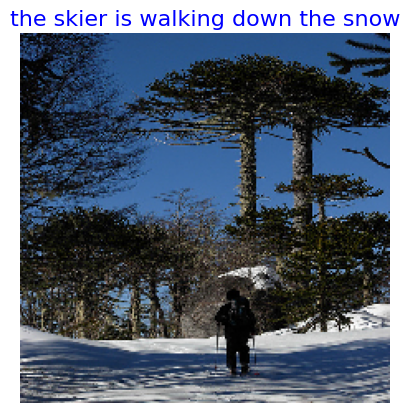

In [21]:
image_path = image_path = "dataset/Images/938162709_21443d352f.jpg"  # Replace with the path to the input image
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

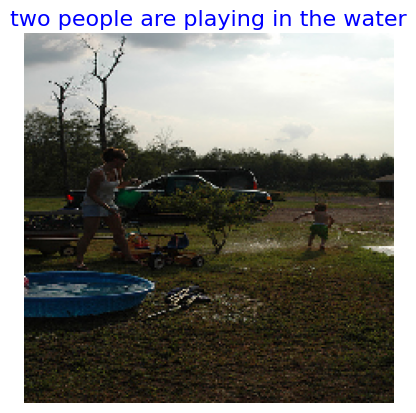

In [22]:
image_path = image_path = "dataset/Images/974924582_10bed89b8d.jpg"  # Replace with the path to the input image
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)